# Bridge Pledge

### Import supporting Libaries

In [21]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

### Metadata - Base Table

In [22]:
meta_data = pd.read_excel('/Users/liz/Documents/IU/DSIP/Week6/BP/Bridge Grade - BETA/Modeling/Model Sept 2024/Model-House-Beta-1.1.xlsx')
#meta_data.head(5)
meta_data = meta_data.loc[:, ['bioguide_id', 'first name','last name', 'full name', 'party name', 'party letter','district','state','STATUS']]
meta_data.head(5)

,bioguide_id,first name,last name,full name,party name,party letter,district,state,STATUS
0,P000619,Mary Sattler,Peltola,Mary Sattler Peltola,Democratic,D,AK-AL,AK,running
1,C001054,Jerry L.,Carl,Jerry L. Carl,Republican,R,AL-01,AL,running
2,M001212,Barry,Moore,Barry Moore,Republican,R,AL-02,AL,running
3,R000575,Mike D.,Rogers,Mike D. Rogers,Republican,R,AL-03,AL,running
4,A000055,Robert B.,Aderholt,Robert B. Aderholt,Republican,R,AL-04,AL,running


### Source Data 

In [23]:
# Load and filter the source file
source_A = pd.read_excel('/Users/liz/Documents/IU/DSIP/Week6/BP/Bridge Grade - BETA/3rd Party Raw Data/Scores-House-GovTrack-Author-Bill-with-Cosponsor.xlsx')
source_A = source_A[['bioguide_id', 'bills-with-cosponsor-other-party']]

# Merge source_A with meta_data on 'bioguide_id'
final = pd.merge(meta_data, source_A, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'bills-with-cosponsor-other-party' with the column mean
mean_A = round(source_A['bills-with-cosponsor-other-party'].mean(), 2)
final['bills-with-cosponsor-other-party'] = final['bills-with-cosponsor-other-party'].fillna(mean_A)

# Calculate mean and standard deviation for normalization
mean_A = round(final['bills-with-cosponsor-other-party'].mean(), 2)
std_A = round(final['bills-with-cosponsor-other-party'].std(), 2)

# Normalize the 'bills-with-cosponsor-other-party' column
final['norm_A'] = norm.cdf(final['bills-with-cosponsor-other-party'], mean_A, std_A) * 100

# Remove duplicates based on 'bioguide_id'
if final['bioguide_id'].duplicated().sum() > 0:
    final.drop_duplicates(subset='bioguide_id', inplace=True)

# Preview the final DataFrame
final.head(5)


,bioguide_id,first name,last name,full name,party name,party letter,district,state,STATUS,bills-with-cosponsor-other-party,norm_A
0,P000619,Mary Sattler,Peltola,Mary Sattler Peltola,Democratic,D,AK-AL,AK,running,1.0,11.203115
1,C001054,Jerry L.,Carl,Jerry L. Carl,Republican,R,AL-01,AL,running,1.0,11.203115
2,M001212,Barry,Moore,Barry Moore,Republican,R,AL-02,AL,running,2.0,14.124263
3,R000575,Mike D.,Rogers,Mike D. Rogers,Republican,R,AL-03,AL,running,0.0,8.741593
4,A000055,Robert B.,Aderholt,Robert B. Aderholt,Republican,R,AL-04,AL,running,1.0,11.203115


### Source Data 

In [24]:
# Load and filter the source file
source_B = pd.read_excel('/Users/liz/Documents/IU/DSIP/Week6/BP/Bridge Grade - BETA/3rd Party Raw Data/Scores-House-CGS-2024.04.xlsx')
source_B = source_B[['biocode', 'cg_official_performance']]

# Merge source_B with the final DataFrame on 'bioguide_id'
final = pd.merge(final, source_B, left_on='bioguide_id', right_on='biocode', how='left')

# Fill missing values in 'cg_official_performance' with the column mean
mean_B = round(source_B['cg_official_performance'].mean(), 2)
final['cg_official_performance'] = final['cg_official_performance'].fillna(mean_B)

# Drop the 'biocode' column after merging
final.drop('biocode', axis=1, inplace=True)

# Calculate mean and standard deviation for normalization
mean_B = round(final['cg_official_performance'].mean(), 2)
std_B = round(final['cg_official_performance'].std(), 2)

# Normalize the 'cg_official_performance' column
final['norm_B'] = norm.cdf(final['cg_official_performance'], mean_B, std_B) * 100

# Remove duplicates based on 'bioguide_id'
if final['bioguide_id'].duplicated().sum() > 0:
    final.drop_duplicates(subset='bioguide_id', inplace=True)

# Preview the final DataFrame
final.head(5)

,bioguide_id,first name,last name,full name,party name,party letter,district,state,STATUS,bills-with-cosponsor-other-party,norm_A,cg_official_performance,norm_B
0,P000619,Mary Sattler,Peltola,Mary Sattler Peltola,Democratic,D,AK-AL,AK,running,1.0,11.203115,11,69.121759
1,C001054,Jerry L.,Carl,Jerry L. Carl,Republican,R,AL-01,AL,running,1.0,11.203115,5,36.874173
2,M001212,Barry,Moore,Barry Moore,Republican,R,AL-02,AL,running,2.0,14.124263,5,36.874173
3,R000575,Mike D.,Rogers,Mike D. Rogers,Republican,R,AL-03,AL,running,0.0,8.741593,5,36.874173
4,A000055,Robert B.,Aderholt,Robert B. Aderholt,Republican,R,AL-04,AL,running,1.0,11.203115,0,15.136467


In [25]:
# Load and filter the source file
source_D = pd.read_excel('/Users/liz/Documents/IU/DSIP/Week6/BP/Bridge Grade - BETA/3rd Party Raw Data/Scores-House-Lugar-Bipartisan.xlsx')
source_D = source_D[['bioguide', 'lugar_score']]

# Merge source_D with the final DataFrame on 'bioguide_id'
final = pd.merge(final, source_D, left_on='bioguide_id', right_on='bioguide', how='left')

# Fill missing values in 'lugar_score' with the column mean
mean_D = round(source_D['lugar_score'].mean(), 2)
final['lugar_score'] = final['lugar_score'].fillna(mean_D)

# Drop the 'bioguide' column after merging
final.drop('bioguide', axis=1, inplace=True)

# Calculate mean and standard deviation for normalization
mean_D = round(final['lugar_score'].mean(), 2)
std_D = round(final['lugar_score'].std(), 2)

# Normalize the 'lugar_score' column
final['norm_D'] = norm.cdf(final['lugar_score'], mean_D, std_D) * 100

# Remove duplicates based on 'bioguide_id'
if final['bioguide_id'].duplicated().sum() > 0:
    final.drop_duplicates(subset='bioguide_id', inplace=True)

# Preview the final DataFrame
final.head(5)

,bioguide_id,first name,last name,full name,party name,party letter,district,state,STATUS,bills-with-cosponsor-other-party,norm_A,cg_official_performance,norm_B,lugar_score,norm_D
0,P000619,Mary Sattler,Peltola,Mary Sattler Peltola,Democratic,D,AK-AL,AK,running,1.0,11.203115,11,69.121759,-0.00913,66.392127
1,C001054,Jerry L.,Carl,Jerry L. Carl,Republican,R,AL-01,AL,running,1.0,11.203115,5,36.874173,-0.55083,42.908663
2,M001212,Barry,Moore,Barry Moore,Republican,R,AL-02,AL,running,2.0,14.124263,5,36.874173,-0.61232,40.244551
3,R000575,Mike D.,Rogers,Mike D. Rogers,Republican,R,AL-03,AL,running,0.0,8.741593,5,36.874173,-0.59239,41.103718
4,A000055,Robert B.,Aderholt,Robert B. Aderholt,Republican,R,AL-04,AL,running,1.0,11.203115,0,15.136467,-1.04601,23.303142


### Source Data 

In [26]:
# Load and filter the source file
source_E = pd.read_excel('/Users/liz/Documents/IU/DSIP/Week6/BP/Bridge Grade - BETA/3rd Party Raw Data/Scores-House-GovTrack-Cosponsor-others-bills.xlsx')
source_E = source_E[['bioguide_id', 'cosponsored-other-party']]

# Merge source_E with the final DataFrame on 'bioguide_id'
final = pd.merge(final, source_E, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'cosponsored-other-party' with the column mean
mean_E = round(source_E['cosponsored-other-party'].mean(), 2)
final['cosponsored-other-party'] = final['cosponsored-other-party'].fillna(mean_E)

# Calculate mean and standard deviation for normalization
mean_E = round(final['cosponsored-other-party'].mean(), 2)
std_E = round(final['cosponsored-other-party'].std(), 2)

# Normalize the 'cosponsored-other-party' column
final['norm_E'] = norm.cdf(final['cosponsored-other-party'], mean_E, std_E) * 100

# Remove duplicates based on 'bioguide_id'
if final['bioguide_id'].duplicated().sum() > 0:
    final.drop_duplicates(subset='bioguide_id', inplace=True)

# Output the preview the updated DataFrame
final.head(5)

,bioguide_id,first name,last name,full name,party name,party letter,district,state,STATUS,bills-with-cosponsor-other-party,norm_A,cg_official_performance,norm_B,lugar_score,norm_D,cosponsored-other-party,norm_E
0,P000619,Mary Sattler,Peltola,Mary Sattler Peltola,Democratic,D,AK-AL,AK,running,1.0,11.203115,11,69.121759,-0.00913,66.392127,17.391304,51.545857
1,C001054,Jerry L.,Carl,Jerry L. Carl,Republican,R,AL-01,AL,running,1.0,11.203115,5,36.874173,-0.55083,42.908663,20.754717,62.375394
2,M001212,Barry,Moore,Barry Moore,Republican,R,AL-02,AL,running,2.0,14.124263,5,36.874173,-0.61232,40.244551,15.358362,44.890664
3,R000575,Mike D.,Rogers,Mike D. Rogers,Republican,R,AL-03,AL,running,0.0,8.741593,5,36.874173,-0.59239,41.103718,34.415584,92.489380
4,A000055,Robert B.,Aderholt,Robert B. Aderholt,Republican,R,AL-04,AL,running,1.0,11.203115,0,15.136467,-1.04601,23.303142,25.149701,75.072868


### Source Data 

In [27]:
# Load and filter the source file
source_F1 = pd.read_excel('/Users/liz/Documents/IU/DSIP/Week6/BP/Bridge Grade - BETA/3rd Party Raw Data/Scores-Both-PRL.xlsx')
source_F1 = source_F1[['bioguide_id', 'communication_outcome_bipartisanship_sum']]

# Merge source_F1 with the final DataFrame on 'bioguide_id'
final = pd.merge(final, source_F1, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'communication_outcome_bipartisanship_sum' with the column mean
mean_F1 = round(source_F1['communication_outcome_bipartisanship_sum'].mean(), 2)
final['communication_outcome_bipartisanship_sum'] = final['communication_outcome_bipartisanship_sum'].fillna(mean_F1)

# Calculate mean and standard deviation for normalization
mean_F1 = round(final['communication_outcome_bipartisanship_sum'].mean(), 2)
std_F1 = round(final['communication_outcome_bipartisanship_sum'].std(), 2)

# Normalize the 'communication_outcome_bipartisanship_sum' column
final['norm_F1'] = norm.cdf(final['communication_outcome_bipartisanship_sum'], mean_F1, std_F1) * 100

# Remove duplicates based on 'bioguide_id'
if final['bioguide_id'].duplicated().sum() > 0:
    final.drop_duplicates(subset='bioguide_id', inplace=True)

# Output the preview the updated DataFrame
final.head(5)

,bioguide_id,first name,last name,full name,party name,party letter,district,state,STATUS,bills-with-cosponsor-other-party,norm_A,cg_official_performance,norm_B,lugar_score,norm_D,cosponsored-other-party,norm_E,communication_outcome_bipartisanship_sum,norm_F1
0,P000619,Mary Sattler,Peltola,Mary Sattler Peltola,Democratic,D,AK-AL,AK,running,1.0,11.203115,11,69.121759,-0.00913,66.392127,17.391304,51.545857,76,33.294017
1,C001054,Jerry L.,Carl,Jerry L. Carl,Republican,R,AL-01,AL,running,1.0,11.203115,5,36.874173,-0.55083,42.908663,20.754717,62.375394,12,16.920703
2,M001212,Barry,Moore,Barry Moore,Republican,R,AL-02,AL,running,2.0,14.124263,5,36.874173,-0.61232,40.244551,15.358362,44.890664,32,21.386373
3,R000575,Mike D.,Rogers,Mike D. Rogers,Republican,R,AL-03,AL,running,0.0,8.741593,5,36.874173,-0.59239,41.103718,34.415584,92.489380,35,22.110879
4,A000055,Robert B.,Aderholt,Robert B. Aderholt,Republican,R,AL-04,AL,running,1.0,11.203115,0,15.136467,-1.04601,23.303142,25.149701,75.072868,10,16.509648


### Source Data 

In [28]:
# Load and filter the source file
source_F2 = pd.read_excel('/Users/liz/Documents/IU/DSIP/Week6/BP/Bridge Grade - BETA/3rd Party Raw Data/Scores-Both-PRL.xlsx')
source_F2 = source_F2[['bioguide_id', 'communication_outcome_bipartisanship_mean']]

# Merge source_F2 with the final DataFrame on 'bioguide_id'
final = pd.merge(final, source_F2, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'communication_outcome_bipartisanship_mean' with the column mean
mean_F2 = round(source_F2['communication_outcome_bipartisanship_mean'].mean(), 2)
final['communication_outcome_bipartisanship_mean'] = final['communication_outcome_bipartisanship_mean'].fillna(mean_F2)

# Calculate mean and standard deviation for normalization
mean_F2 = round(final['communication_outcome_bipartisanship_mean'].mean(), 2)
std_F2 = round(final['communication_outcome_bipartisanship_mean'].std(), 2)

# Normalize the 'communication_outcome_bipartisanship_mean' column
final['norm_F2'] = norm.cdf(final['communication_outcome_bipartisanship_mean'], mean_F2, std_F2) * 100

# Remove duplicates based on 'bioguide_id'
if final['bioguide_id'].duplicated().sum() > 0:
    final.drop_duplicates(subset='bioguide_id', inplace=True)

# Output the preview the updated DataFrame
final.head(5)

,bioguide_id,first name,last name,full name,party name,party letter,district,state,STATUS,bills-with-cosponsor-other-party,...,cg_official_performance,norm_B,lugar_score,norm_D,cosponsored-other-party,norm_E,communication_outcome_bipartisanship_sum,norm_F1,communication_outcome_bipartisanship_mean,norm_F2
0,P000619,Mary Sattler,Peltola,Mary Sattler Peltola,Democratic,D,AK-AL,AK,running,1.0,...,11,69.121759,-0.00913,66.392127,17.391304,51.545857,76,33.294017,7.41,73.014767
1,C001054,Jerry L.,Carl,Jerry L. Carl,Republican,R,AL-01,AL,running,1.0,...,5,36.874173,-0.55083,42.908663,20.754717,62.375394,12,16.920703,1.78,17.309915
2,M001212,Barry,Moore,Barry Moore,Republican,R,AL-02,AL,running,2.0,...,5,36.874173,-0.61232,40.244551,15.358362,44.890664,32,21.386373,1.70,16.750080
3,R000575,Mike D.,Rogers,Mike D. Rogers,Republican,R,AL-03,AL,running,0.0,...,5,36.874173,-0.59239,41.103718,34.415584,92.489380,35,22.110879,3.29,29.983961
4,A000055,Robert B.,Aderholt,Robert B. Aderholt,Republican,R,AL-04,AL,running,1.0,...,0,15.136467,-1.04601,23.303142,25.149701,75.072868,10,16.509648,1.76,17.168851


### Source Data 

In [29]:
# Load and filter the source file
source_G = pd.read_excel('/Users/liz/Documents/IU/DSIP/Week6/BP/Bridge Grade - BETA/3rd Party Raw Data/Scores-House-CGS-2024.04.xlsx')
source_G = source_G[['biocode', 'cg_bonus']]

# Merge source_G with the final DataFrame on 'bioguide_id'
final = pd.merge(final, source_G, left_on='bioguide_id', right_on='biocode', how='left')

# Fill missing values in 'cg_bonus' with the column mean
mean_G = round(source_G['cg_bonus'].mean(), 2)
final['cg_bonus'] = final['cg_bonus'].fillna(mean_G)

# Drop 'biocode' column after merge
final.drop('biocode', axis=1, inplace=True)

# Calculate mean and standard deviation for normalization
mean_G = round(final['cg_bonus'].mean(), 2)
std_G = round(final['cg_bonus'].std(), 2)

# Normalize the 'cg_bonus' column
final['norm_G'] = norm.cdf(final['cg_bonus'], mean_G, std_G) * 100

# Remove duplicates based on 'bioguide_id'
if final['bioguide_id'].duplicated().sum() > 0:
    final.drop_duplicates(subset='bioguide_id', inplace=True)

# Output the preview the updated DataFrame
final.head(5)

,bioguide_id,first name,last name,full name,party name,party letter,district,state,STATUS,bills-with-cosponsor-other-party,...,lugar_score,norm_D,cosponsored-other-party,norm_E,communication_outcome_bipartisanship_sum,norm_F1,communication_outcome_bipartisanship_mean,norm_F2,cg_bonus,norm_G
0,P000619,Mary Sattler,Peltola,Mary Sattler Peltola,Democratic,D,AK-AL,AK,running,1.0,...,-0.00913,66.392127,17.391304,51.545857,76,33.294017,7.41,73.014767,0,32.45451
1,C001054,Jerry L.,Carl,Jerry L. Carl,Republican,R,AL-01,AL,running,1.0,...,-0.55083,42.908663,20.754717,62.375394,12,16.920703,1.78,17.309915,0,32.45451
2,M001212,Barry,Moore,Barry Moore,Republican,R,AL-02,AL,running,2.0,...,-0.61232,40.244551,15.358362,44.890664,32,21.386373,1.70,16.750080,0,32.45451
3,R000575,Mike D.,Rogers,Mike D. Rogers,Republican,R,AL-03,AL,running,0.0,...,-0.59239,41.103718,34.415584,92.489380,35,22.110879,3.29,29.983961,0,32.45451
4,A000055,Robert B.,Aderholt,Robert B. Aderholt,Republican,R,AL-04,AL,running,1.0,...,-1.04601,23.303142,25.149701,75.072868,10,16.509648,1.76,17.168851,0,32.45451


### Source Data 

In [30]:
# Load and filter the source file for cg_communications
source_H = pd.read_excel('/Users/liz/Documents/IU/DSIP/Week6/BP/Bridge Grade - BETA/3rd Party Raw Data/Scores-House-CGS-2024.04.xlsx')
source_H = source_H[['biocode', 'cg_communications']]

# Merge source_H with the final DataFrame on 'bioguide_id'
final = pd.merge(final, source_H, left_on='bioguide_id', right_on='biocode', how='left')

# Fill missing values in 'cg_communications' with the column mean
mean_H = round(source_H['cg_communications'].mean(), 2)
final['cg_communications'] = final['cg_communications'].fillna(mean_H)

# Drop 'biocode' column after merge
final.drop('biocode', axis=1, inplace=True)

# Calculate mean and standard deviation for normalization
mean_H = round(final['cg_communications'].mean(), 2)
std_H = round(final['cg_communications'].std(), 2)

# Normalize the 'cg_communications' column
final['norm_H'] = norm.cdf(final['cg_communications'], mean_H, std_H) * 100

# Remove duplicates based on 'bioguide_id'
if final['bioguide_id'].duplicated().sum() > 0:
    final.drop_duplicates(subset='bioguide_id', inplace=True)

# Output the preview the updated DataFrame
final.head(5)

,bioguide_id,first name,last name,full name,party name,party letter,district,state,STATUS,bills-with-cosponsor-other-party,...,cosponsored-other-party,norm_E,communication_outcome_bipartisanship_sum,norm_F1,communication_outcome_bipartisanship_mean,norm_F2,cg_bonus,norm_G,cg_communications,norm_H
0,P000619,Mary Sattler,Peltola,Mary Sattler Peltola,Democratic,D,AK-AL,AK,running,1.0,...,17.391304,51.545857,76,33.294017,7.41,73.014767,0,32.45451,20,78.944912
1,C001054,Jerry L.,Carl,Jerry L. Carl,Republican,R,AL-01,AL,running,1.0,...,20.754717,62.375394,12,16.920703,1.78,17.309915,0,32.45451,0,14.114529
2,M001212,Barry,Moore,Barry Moore,Republican,R,AL-02,AL,running,2.0,...,15.358362,44.890664,32,21.386373,1.70,16.750080,0,32.45451,0,14.114529
3,R000575,Mike D.,Rogers,Mike D. Rogers,Republican,R,AL-03,AL,running,0.0,...,34.415584,92.489380,35,22.110879,3.29,29.983961,0,32.45451,0,14.114529
4,A000055,Robert B.,Aderholt,Robert B. Aderholt,Republican,R,AL-04,AL,running,1.0,...,25.149701,75.072868,10,16.509648,1.76,17.168851,0,32.45451,20,78.944912


### Source Data 

In [31]:
# Load and filter the source file for communication_attack_personal_sum
source_I1 = pd.read_excel('/Users/liz/Documents/IU/DSIP/Week6/BP/Bridge Grade - BETA/3rd Party Raw Data/Scores-Both-PRL.xlsx')
source_I1 = source_I1[['bioguide_id', 'communication_attack_personal_sum']]

# Merge source_I1 with the final DataFrame on 'bioguide_id'
final = pd.merge(final, source_I1, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'communication_attack_personal_sum' with the column mean
mean_I1 = round(source_I1['communication_attack_personal_sum'].mean(), 2)
final['communication_attack_personal_sum'] = final['communication_attack_personal_sum'].fillna(mean_I1)

# Calculate mean and standard deviation for normalization
mean_I1 = round(final['communication_attack_personal_sum'].mean(), 2)
std_I1 = round(final['communication_attack_personal_sum'].std(), 2)

# Normalize the 'communication_attack_personal_sum' column
final['norm_I1'] = norm.cdf(final['communication_attack_personal_sum'], mean_I1, std_I1) * 100

# Remove duplicates based on 'bioguide_id'
if final['bioguide_id'].duplicated().sum() > 0:
    final.drop_duplicates(subset='bioguide_id', inplace=True)

# Output the preview the updated DataFrame
final.head(5)

,bioguide_id,first name,last name,full name,party name,party letter,district,state,STATUS,bills-with-cosponsor-other-party,...,communication_outcome_bipartisanship_sum,norm_F1,communication_outcome_bipartisanship_mean,norm_F2,cg_bonus,norm_G,cg_communications,norm_H,communication_attack_personal_sum,norm_I1
0,P000619,Mary Sattler,Peltola,Mary Sattler Peltola,Democratic,D,AK-AL,AK,running,1.0,...,76,33.294017,7.41,73.014767,0,32.45451,20,78.944912,2,29.063346
1,C001054,Jerry L.,Carl,Jerry L. Carl,Republican,R,AL-01,AL,running,1.0,...,12,16.920703,1.78,17.309915,0,32.45451,0,14.114529,26,39.776460
2,M001212,Barry,Moore,Barry Moore,Republican,R,AL-02,AL,running,2.0,...,32,21.386373,1.70,16.750080,0,32.45451,0,14.114529,47,49.868769
3,R000575,Mike D.,Rogers,Mike D. Rogers,Republican,R,AL-03,AL,running,0.0,...,35,22.110879,3.29,29.983961,0,32.45451,0,14.114529,17,35.614342
4,A000055,Robert B.,Aderholt,Robert B. Aderholt,Republican,R,AL-04,AL,running,1.0,...,10,16.509648,1.76,17.168851,0,32.45451,20,78.944912,5,30.328162


### Source Data 

In [32]:
# Load and filter the source file for communication_attack_personal_mean
source_I2 = pd.read_excel('/Users/liz/Documents/IU/DSIP/Week6/BP/Bridge Grade - BETA/3rd Party Raw Data/Scores-Both-PRL.xlsx')
source_I2 = source_I2[['bioguide_id', 'communication_attack_personal_mean']]

# Merge source_I2 with the final DataFrame on 'bioguide_id'
final = pd.merge(final, source_I2, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'communication_attack_personal_mean' with the column mean
mean_I2 = round(source_I2['communication_attack_personal_mean'].mean(), 2)
final['communication_attack_personal_mean'] = final['communication_attack_personal_mean'].fillna(mean_I2)

# Calculate mean and standard deviation for normalization
mean_I2 = round(final['communication_attack_personal_mean'].mean(), 2)
std_I2 = round(final['communication_attack_personal_mean'].std(), 2)

# Normalize the 'communication_attack_personal_mean' column
final['norm_I2'] = norm.cdf(final['communication_attack_personal_mean'], mean_I2, std_I2) * 100

# Remove duplicates based on 'bioguide_id'
if final['bioguide_id'].duplicated().sum() > 0:
    final.drop_duplicates(subset='bioguide_id', inplace=True)

# Output the preview the updated DataFrame
final.head(5)

,bioguide_id,first name,last name,full name,party name,party letter,district,state,STATUS,bills-with-cosponsor-other-party,...,communication_outcome_bipartisanship_mean,norm_F2,cg_bonus,norm_G,cg_communications,norm_H,communication_attack_personal_sum,norm_I1,communication_attack_personal_mean,norm_I2
0,P000619,Mary Sattler,Peltola,Mary Sattler Peltola,Democratic,D,AK-AL,AK,running,1.0,...,7.41,73.014767,0,32.45451,20,78.944912,2,29.063346,0.19,24.165763
1,C001054,Jerry L.,Carl,Jerry L. Carl,Republican,R,AL-01,AL,running,1.0,...,1.78,17.309915,0,32.45451,0,14.114529,26,39.776460,3.85,86.283323
2,M001212,Barry,Moore,Barry Moore,Republican,R,AL-02,AL,running,2.0,...,1.70,16.750080,0,32.45451,0,14.114529,47,49.868769,2.50,66.690125
3,R000575,Mike D.,Rogers,Mike D. Rogers,Republican,R,AL-03,AL,running,0.0,...,3.29,29.983961,0,32.45451,0,14.114529,17,35.614342,1.60,49.608886
4,A000055,Robert B.,Aderholt,Robert B. Aderholt,Republican,R,AL-04,AL,running,1.0,...,1.76,17.168851,0,32.45451,20,78.944912,5,30.328162,0.88,35.839765


### Source Data 

In [33]:
# Load and filter the source file for 'cg_personal_actions' and 'cg_commitments'
source_K = pd.read_excel('/Users/liz/Documents/IU/DSIP/Week6/BP/Bridge Grade - BETA/3rd Party Raw Data/Scores-House-CGS-2024.04.xlsx', engine='openpyxl')
source_K = source_K[['biocode', 'cg_personal_actions', 'cg_commitments']]

# Combine 'cg_personal_actions' and 'cg_commitments' into a new column 'personal_actions/commitments'
source_K['personal_actions/commitments'] = source_K['cg_personal_actions'] + source_K['cg_commitments']

# Drop the original columns
source_K.drop(['cg_personal_actions', 'cg_commitments'], axis=1, inplace=True)

# Preview the modified source DataFrame
source_K.head()

# Merge source_K with the final DataFrame on 'bioguide_id' and 'biocode'
final = pd.merge(final, source_K, left_on='bioguide_id', right_on='biocode', how='left')

# Fill missing values in 'personal_actions/commitments' with the column mean
mean_K = round(source_K['personal_actions/commitments'].mean(), 2)
final['personal_actions/commitments'] = final['personal_actions/commitments'].fillna(mean_K)

# Calculate mean and standard deviation for normalization
mean_K = round(final['personal_actions/commitments'].mean(), 2)
std_K = round(final['personal_actions/commitments'].std(), 2)

# Normalize the 'personal_actions/commitments' column
final['norm_K'] = norm.cdf(final['personal_actions/commitments'], mean_K, std_K) * 100

# Drop the 'biocode' column after the merge
final.drop('biocode', axis=1, inplace=True)

# Remove duplicates based on 'bioguide_id'
if final['bioguide_id'].duplicated().sum() > 0:
    final.drop_duplicates(subset='bioguide_id', inplace=True)

# Output the preview the updated DataFrame
final.head(5)

,bioguide_id,first name,last name,full name,party name,party letter,district,state,STATUS,bills-with-cosponsor-other-party,...,cg_bonus,norm_G,cg_communications,norm_H,communication_attack_personal_sum,norm_I1,communication_attack_personal_mean,norm_I2,personal_actions/commitments,norm_K
0,P000619,Mary Sattler,Peltola,Mary Sattler Peltola,Democratic,D,AK-AL,AK,running,1.0,...,0,32.45451,20,78.944912,2,29.063346,0.19,24.165763,10,50.577276
1,C001054,Jerry L.,Carl,Jerry L. Carl,Republican,R,AL-01,AL,running,1.0,...,0,32.45451,0,14.114529,26,39.776460,3.85,86.283323,0,22.748834
2,M001212,Barry,Moore,Barry Moore,Republican,R,AL-02,AL,running,2.0,...,0,32.45451,0,14.114529,47,49.868769,2.50,66.690125,0,22.748834
3,R000575,Mike D.,Rogers,Mike D. Rogers,Republican,R,AL-03,AL,running,0.0,...,0,32.45451,0,14.114529,17,35.614342,1.60,49.608886,10,50.577276
4,A000055,Robert B.,Aderholt,Robert B. Aderholt,Republican,R,AL-04,AL,running,1.0,...,0,32.45451,20,78.944912,5,30.328162,0.88,35.839765,0,22.748834


### Source Data 

In [34]:
# Load the source file for 'nominate_dim2' from 'Scores-Both-VoteView.xlsx'
source_L = pd.read_excel('/Users/liz/Documents/IU/DSIP/Week6/BP/Bridge Grade - BETA/3rd Party Raw Data/Scores-Both-VoteView.xlsx')

# Filter columns to keep only 'bioguide_id' and 'nominate_dim2'
source_L = source_L[['bioguide_id', 'nominate_dim2']]

# Preview the filtered source DataFrame
source_L.head()

# Merge source_L with the final DataFrame on 'bioguide_id'
final = pd.merge(final, source_L, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'nominate_dim2' with the column mean
mean_L = round(source_L['nominate_dim2'].mean(), 2)
final['nominate_dim2'] = final['nominate_dim2'].fillna(mean_L)

# Calculate mean and standard deviation for normalization
mean_L = round(final['nominate_dim2'].mean(), 2)
std_L = round(final['nominate_dim2'].std(), 2)

# Normalize the 'nominate_dim2' column
final['norm_L'] = norm.cdf(final['nominate_dim2'], mean_L, std_L) * 100

# Drop duplicates based on 'bioguide_id' if any exist
if final['bioguide_id'].duplicated().sum() > 0:
    final.drop_duplicates(subset='bioguide_id', inplace=True)

# Output the preview the updated DataFrame
final.head(5)

,bioguide_id,first name,last name,full name,party name,party letter,district,state,STATUS,bills-with-cosponsor-other-party,...,cg_communications,norm_H,communication_attack_personal_sum,norm_I1,communication_attack_personal_mean,norm_I2,personal_actions/commitments,norm_K,nominate_dim2,norm_L
0,P000619,Mary Sattler,Peltola,Mary Sattler Peltola,Democratic,D,AK-AL,AK,running,1.0,...,20,78.944912,2,29.063346,0.19,24.165763,10,50.577276,0.382,90.612114
2,C001054,Jerry L.,Carl,Jerry L. Carl,Republican,R,AL-01,AL,running,1.0,...,0,14.114529,26,39.776460,3.85,86.283323,0,22.748834,0.236,79.211826
4,M001212,Barry,Moore,Barry Moore,Republican,R,AL-02,AL,running,2.0,...,0,14.114529,47,49.868769,2.50,66.690125,0,22.748834,-0.244,20.006774
6,R000575,Mike D.,Rogers,Mike D. Rogers,Republican,R,AL-03,AL,running,0.0,...,0,14.114529,17,35.614342,1.60,49.608886,10,50.577276,0.380,90.496040
17,A000055,Robert B.,Aderholt,Robert B. Aderholt,Republican,R,AL-04,AL,running,1.0,...,20,78.944912,5,30.328162,0.88,35.839765,0,22.748834,0.467,94.633870


### Source Data 

In [35]:
# Load the source file for 'nominate_dim1' from 'Scores-Both-VoteView.xlsx'
source_N = pd.read_excel('/Users/liz/Documents/IU/DSIP/Week6/BP/Bridge Grade - BETA/3rd Party Raw Data/Scores-Both-VoteView.xlsx', engine='openpyxl')

# Filter columns to keep only 'bioguide_id' and 'nominate_dim1'
source_N = source_N[['bioguide_id', 'nominate_dim1']]

# Preview the filtered source DataFrame
source_N.head()

# Merge source_N with the final DataFrame on 'bioguide_id'
final = pd.merge(final, source_N, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'nominate_dim1' with the column mean
mean_N = round(source_N['nominate_dim1'].mean(), 2)
final['nominate_dim1'] = final['nominate_dim1'].fillna(mean_N)

# Calculate mean and standard deviation for normalization
mean_N = round(final['nominate_dim1'].mean(), 2)
std_N = round(final['nominate_dim1'].std(), 2)

# Normalize the 'nominate_dim1' column
final['norm_N'] = norm.cdf(final['nominate_dim1'], mean_N, std_N) * 100

# Drop duplicates based on 'bioguide_id' if any exist
if final['bioguide_id'].duplicated().sum() > 0:
    final.drop_duplicates(subset='bioguide_id', inplace=True)

# Output the preview the updated DataFrame
final.head(5)

,bioguide_id,first name,last name,full name,party name,party letter,district,state,STATUS,bills-with-cosponsor-other-party,...,communication_attack_personal_sum,norm_I1,communication_attack_personal_mean,norm_I2,personal_actions/commitments,norm_K,nominate_dim2,norm_L,nominate_dim1,norm_N
0,P000619,Mary Sattler,Peltola,Mary Sattler Peltola,Democratic,D,AK-AL,AK,running,1.0,...,2,29.063346,0.19,24.165763,10,50.577276,0.382,90.612114,-0.137,39.124064
2,C001054,Jerry L.,Carl,Jerry L. Carl,Republican,R,AL-01,AL,running,1.0,...,26,39.776460,3.85,86.283323,0,22.748834,0.236,79.211826,0.550,88.827232
4,M001212,Barry,Moore,Barry Moore,Republican,R,AL-02,AL,running,2.0,...,47,49.868769,2.50,66.690125,0,22.748834,-0.244,20.006774,0.639,92.085846
6,R000575,Mike D.,Rogers,Mike D. Rogers,Republican,R,AL-03,AL,running,0.0,...,17,35.614342,1.60,49.608886,10,50.577276,0.380,90.496040,0.379,80.112659
17,A000055,Robert B.,Aderholt,Robert B. Aderholt,Republican,R,AL-04,AL,running,1.0,...,5,30.328162,0.88,35.839765,0,22.748834,0.467,94.633870,0.405,81.651775


### Source Data 

In [36]:
# Load the source file for 'ideology_intensity' from 'Scores-Both-PRL.xlsx'
source_O = pd.read_excel('/Users/liz/Documents/IU/DSIP/Week6/BP/Bridge Grade - BETA/3rd Party Raw Data/Scores-Both-PRL.xlsx', engine='openpyxl')

# Filter the columns to keep only 'bioguide_id' and 'ideology_intensity'
source_O = source_O[['bioguide_id', 'ideology_intensity']]

# Preview the filtered source DataFrame
source_O.head()

# Merge source_O with the final DataFrame on 'bioguide_id'
final = pd.merge(final, source_O, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'ideology_intensity' with the column mean
mean_O = round(source_O['ideology_intensity'].mean(), 2)
final['ideology_intensity'] = final['ideology_intensity'].fillna(mean_O)

# Calculate mean and standard deviation for normalization
mean_O = round(final['ideology_intensity'].mean(), 2)
std_O = round(final['ideology_intensity'].std(), 2)

# Normalize the 'ideology_intensity' column
final['norm_O'] = norm.cdf(final['ideology_intensity'], mean_O, std_O) * 100

# Drop duplicates based on 'bioguide_id' if any exist
if final['bioguide_id'].duplicated().sum() > 0:
    final.drop_duplicates(subset='bioguide_id', inplace=True)

# Output the preview the updated DataFrame
final.head(5)

,bioguide_id,first name,last name,full name,party name,party letter,district,state,STATUS,bills-with-cosponsor-other-party,...,communication_attack_personal_mean,norm_I2,personal_actions/commitments,norm_K,nominate_dim2,norm_L,nominate_dim1,norm_N,ideology_intensity,norm_O
0,P000619,Mary Sattler,Peltola,Mary Sattler Peltola,Democratic,D,AK-AL,AK,running,1.0,...,0.19,24.165763,10,50.577276,0.382,90.612114,-0.137,39.124064,0.896315,10.925658
1,C001054,Jerry L.,Carl,Jerry L. Carl,Republican,R,AL-01,AL,running,1.0,...,3.85,86.283323,0,22.748834,0.236,79.211826,0.550,88.827232,1.432320,37.967106
2,M001212,Barry,Moore,Barry Moore,Republican,R,AL-02,AL,running,2.0,...,2.50,66.690125,0,22.748834,-0.244,20.006774,0.639,92.085846,2.044600,77.316491
3,R000575,Mike D.,Rogers,Mike D. Rogers,Republican,R,AL-03,AL,running,0.0,...,1.60,49.608886,10,50.577276,0.380,90.496040,0.379,80.112659,1.032600,15.974238
4,A000055,Robert B.,Aderholt,Robert B. Aderholt,Republican,R,AL-04,AL,running,1.0,...,0.88,35.839765,0,22.748834,0.467,94.633870,0.405,81.651775,1.156020,21.689456


### Source Data 

In [37]:
# Load the source file for '2023_pvi_raw' from 'Meta-District-House-PVI.xlsx'
source_M = pd.read_excel('/Users/liz/Documents/IU/DSIP/Week6/BP/Bridge Grade - BETA/Meta Data/Meta-District-House-PVI.xlsx', engine='openpyxl')

# Filter the columns to keep only 'winner_biocode' and '2023_pvi_raw'
source_M = source_M[['winner_biocode', '2023_pvi_raw']]

# Preview the filtered source DataFrame
source_M.head()

# Merge source_M with the final DataFrame on 'bioguide_id'
final = pd.merge(final, source_M, left_on='bioguide_id', right_on='winner_biocode', how='left')

# Fill missing values in '2023_pvi_raw' with the column mean
mean_M = round(source_M['2023_pvi_raw'].mean(), 2)
final['2023_pvi_raw'] = final['2023_pvi_raw'].fillna(mean_M)

# Calculate mean and standard deviation for normalization
mean_M = round(final['2023_pvi_raw'].mean(), 2)
std_M = round(final['2023_pvi_raw'].std(), 2)

# Normalize the '2023_pvi_raw' column
final['norm_M'] = norm.cdf(final['2023_pvi_raw'], mean_M, std_M) * 100

# Drop the 'winner_biocode' column
final.drop('winner_biocode', axis=1, inplace=True)

# Drop duplicates based on 'bioguide_id' if any exist
if final['bioguide_id'].duplicated().sum() > 0:
    final.drop_duplicates(subset='bioguide_id', inplace=True)

# Output the preview the updated DataFrame
final.head(5)

,bioguide_id,first name,last name,full name,party name,party letter,district,state,STATUS,bills-with-cosponsor-other-party,...,personal_actions/commitments,norm_K,nominate_dim2,norm_L,nominate_dim1,norm_N,ideology_intensity,norm_O,2023_pvi_raw,norm_M
0,P000619,Mary Sattler,Peltola,Mary Sattler Peltola,Democratic,D,AK-AL,AK,running,1.0,...,10,50.577276,0.382,90.612114,-0.137,39.124064,0.896315,10.925658,8.02,25.554453
1,C001054,Jerry L.,Carl,Jerry L. Carl,Republican,R,AL-01,AL,running,1.0,...,0,22.748834,0.236,79.211826,0.550,88.827232,1.432320,37.967106,16.47,62.117622
2,M001212,Barry,Moore,Barry Moore,Republican,R,AL-02,AL,running,2.0,...,0,22.748834,-0.244,20.006774,0.639,92.085846,2.044600,77.316491,17.32,65.752373
3,R000575,Mike D.,Rogers,Mike D. Rogers,Republican,R,AL-03,AL,running,0.0,...,10,50.577276,0.380,90.496040,0.379,80.112659,1.032600,15.974238,19.36,73.854206
4,A000055,Robert B.,Aderholt,Robert B. Aderholt,Republican,R,AL-04,AL,running,1.0,...,0,22.748834,0.467,94.633870,0.405,81.651775,1.156020,21.689456,33.24,98.696418


### Adding Weights

In [38]:
weights = {
    'A': 1,
    'B': 0.5,
    'D': 1.5,
    'E': 1,
    'F1': 0.75,
    'F2': 0.75,
    'G': 0.5,
    'H': 0.5,
    'I1': 0.75,
    'I2': 0.75,
    'K': 0.5,
    'L': 0.5,
    'M': 0.001,
    'N': 0.0005,
    'O': 0.0005
}

print(weights)


{'A': 1, 'B': 0.5, 'D': 1.5, 'E': 1, 'F1': 0.75, 'F2': 0.75, 'G': 0.5, 'H': 0.5, 'I1': 0.75, 'I2': 0.75, 'K': 0.5, 'L': 0.5, 'M': 0.001, 'N': 0.0005, 'O': 0.0005}


### Score Calculation & Final Score

In [39]:
def cal_score(data, weights):
    # Copy the data to avoid modifying the original dataframe
    temp_data = data.copy()
    
    # Initialize columns
    temp_data['score_T'] = 0
    
    # Calculate 'score_T' by adding weighted norm values for each category
    for i in weights.keys():
        temp_data['score_T'] += temp_data[f"norm_{i}"] * weights[i]
    
    # Calculate 'score_S' by adjusting 'score_T' with specific terms based on weights
    temp_data['score_S'] = temp_data['score_T'] * (1 + ((temp_data['norm_M'] * weights['M']) +
                                                       (temp_data['norm_N'] * weights['N']) +
                                                       (temp_data['norm_O'] * weights['O'])))
    
    # Calculate mean, std, and median of 'score_S'
    mean_S = round(temp_data['score_S'].mean(), 2)
    std_S = round(temp_data['score_S'].std(), 2)
    median_S = round(temp_data['score_S'].median(), 2)
    
    # Normalize 'score_S' using the cumulative distribution function (CDF)
    temp_data['norm_S'] = norm.cdf(temp_data['score_S'], mean_S, std_S) * 100
    
    # Define the grade assignment function based on the calculated scores
    def assign_grade(grade):
        if grade > mean_S + std_S:
            return 'A'
        elif grade > median_S:
            return 'B'
        elif grade > mean_S - std_S:
            return 'C'
        else:
            return 'F'
    
    # Apply the grade assignment to the 'score_S' column
    temp_data['Grade'] = temp_data['score_S'].apply(assign_grade)
    
    return temp_data

# Call the function to get the final scores and grades
scores = cal_score(final, weights)
# Display the specific columns
scores[['bioguide_id', 'full name', 'party name', 'score_S', 'Grade']].head(21)

,bioguide_id,full name,party name,score_S,Grade
0,P000619,Mary Sattler Peltola,Democratic,465.297846,B
1,C001054,Jerry L. Carl,Republican,395.040785,C
2,M001212,Barry Moore,Republican,343.586548,C
3,R000575,Mike D. Rogers,Republican,424.363691,C
4,A000055,Robert B. Aderholt,Republican,366.075756,C
5,S001220,Dale W. Strong,Republican,365.475053,C
6,P000609,Gary J. Palmer,Republican,346.885695,C
7,S001185,Terri A. Sewell,Democratic,550.598533,B
8,C001087,"Eric A. ""Rick"" Crawford",Republican,412.068639,C
9,H001072,J. French Hill,Republican,625.620356,A


### Ridge regression model on Final Score with Actual vs. Predicted Values

In [42]:
from sklearn.linear_model import Ridge

def cal_score_with_ridge(data, weights, alpha=1.0):
    # Select the normalized columns as features
    feature_columns = [f"norm_{i}" for i in weights.keys()]
    X = data[feature_columns]

    # Create a weight vector corresponding to the features
    weight_vector = [weights[key] for key in weights.keys()]
    
    # Initialize and train the Ridge regression model
    model = Ridge(alpha=alpha)
    model.fit(X, X.dot(weight_vector))  # Now we multiply with the weight_vector
    
    # Predict the 'score_S' based on learned model
    data['score_S'] = model.predict(X)
    
    # Calculate mean, std, and median of 'score_S'
    mean_S = round(data['score_S'].mean(), 2)
    std_S = round(data['score_S'].std(), 2)
    median_S = round(data['score_S'].median(), 2)

    # Normalize 'score_S' using the cumulative distribution function (CDF)
    data['norm_S'] = norm.cdf(data['score_S'], mean_S, std_S) * 100

    # Grade assignment function
    def assign_grade(grade):
        if grade > mean_S + std_S:
            return 'A'
        elif grade > median_S:
            return 'B'
        elif grade > mean_S - std_S:
            return 'C'
        else:
            return 'F'
    
    # Apply grade assignment to the 'score_S' column
    data['Grade'] = data['score_S'].apply(assign_grade)
    
    return data

# Call the function to get scores with Ridge Regression
scores_ridge = cal_score_with_ridge(final, weights)

### DecisionTreeRegressor on Final Score with Actual vs. Predicted Values

Mean Squared Error: 3463.921728908312


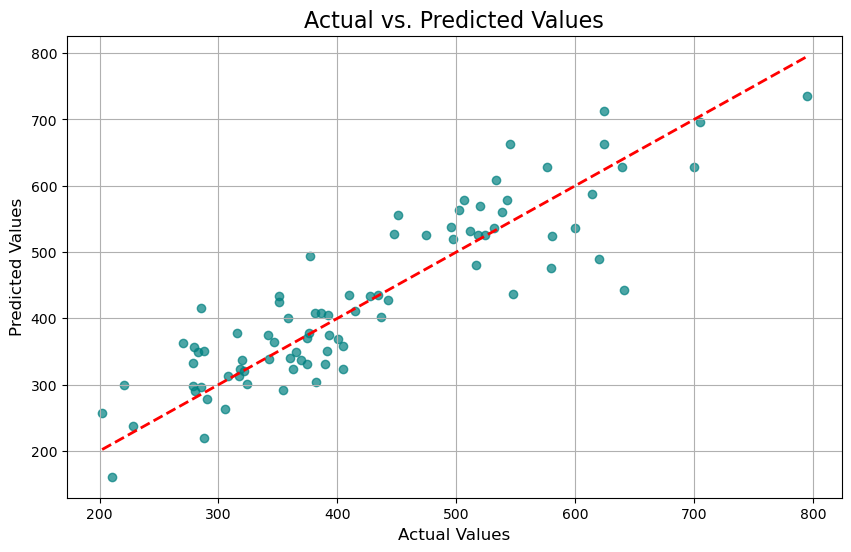

In [43]:
# Define the feature columns (normalized values)
feature_columns = [f"norm_{i}" for i in weights.keys()]

# Create the input matrix X and output vector y
X = scores_ridge[feature_columns]
y = scores_ridge['score_S']

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the DecisionTreeRegressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Train the model
dt_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Optionally, you can visualize the tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='teal')  # Scatter plot
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)  # Line y=x for reference
plt.title("Actual vs. Predicted Values", fontsize=16)
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.grid(True)
plt.show()

### Mean Normalized Scores by Category

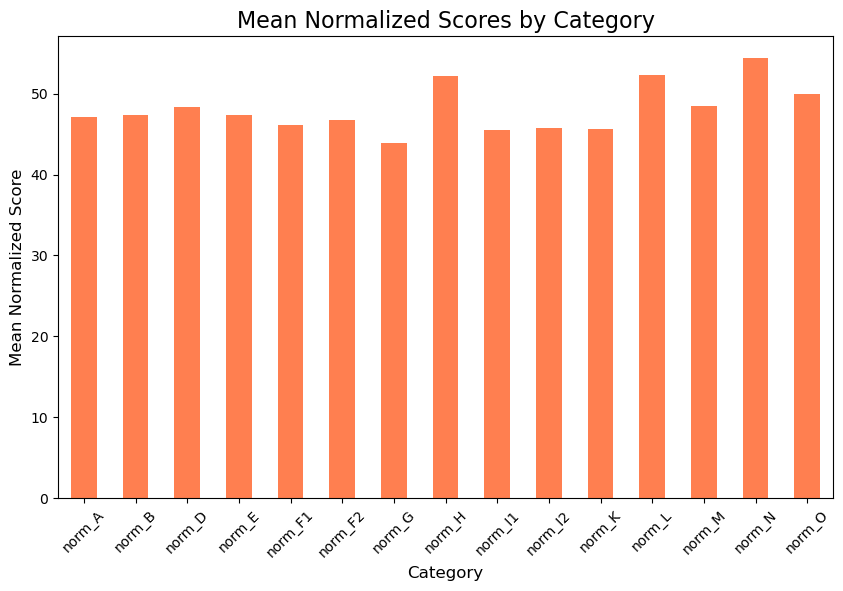

In [44]:
# Bar plot for mean normalized scores for each category
norm_columns = [f"norm_{i}" for i in weights.keys()]

# Calculate mean for each normalized score column
mean_scores = scores_ridge[norm_columns].mean()

plt.figure(figsize=(10, 6))
mean_scores.plot(kind='bar', color='coral')
plt.title('Mean Normalized Scores by Category', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Mean Normalized Score', fontsize=12)
plt.xticks(rotation=45)
plt.show()

### Scatter Plot: score_S vs. norm_S

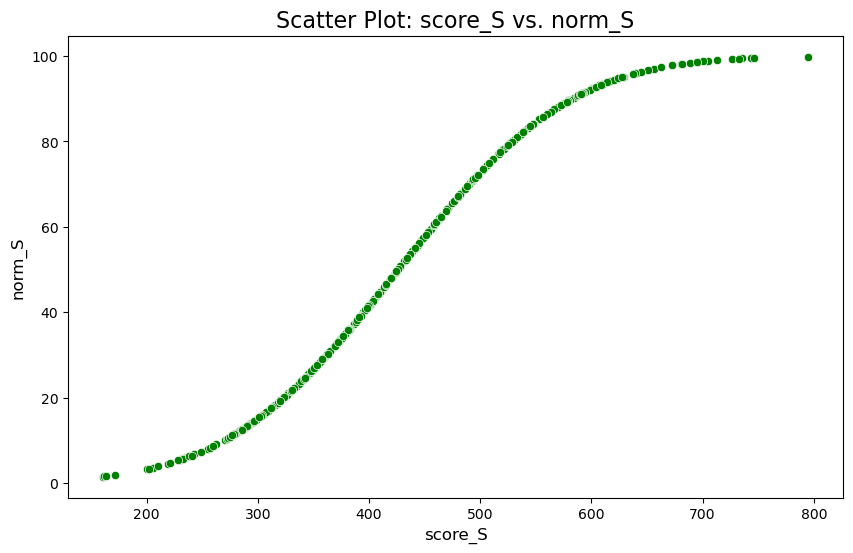

In [45]:
# Scatter plot between 'norm_S' and 'score_S'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='score_S', y='norm_S', data=scores_ridge, color='green')
plt.title('Scatter Plot: score_S vs. norm_S', fontsize=16)
plt.xlabel('score_S', fontsize=12)
plt.ylabel('norm_S', fontsize=12)
plt.show()

### the correlation matrix

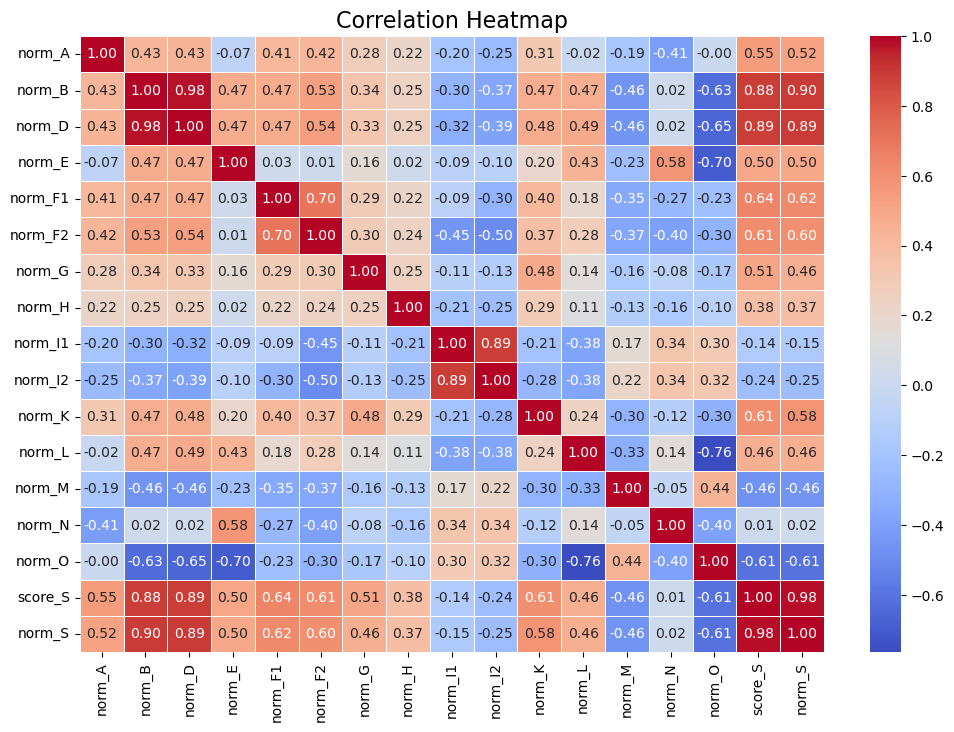

In [46]:
# Calculate the correlation matrix
correlation_matrix = scores_ridge[norm_columns + ['score_S', 'norm_S']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

### the correlation matrix

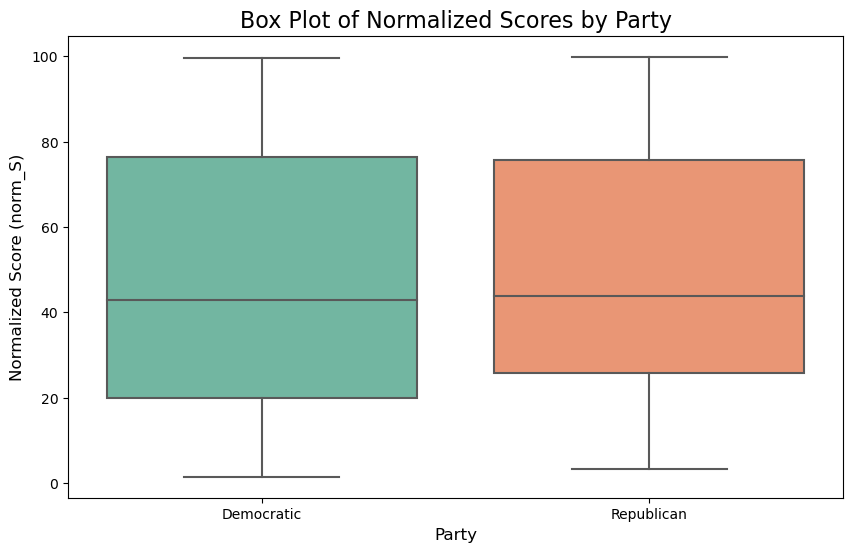

In [47]:
# Box plot for 'norm_S' by 'party' (replace 'party_column' with the actual party column in your data)
plt.figure(figsize=(10, 6))
sns.boxplot(x='party name', y='norm_S', data=scores_ridge, palette='Set2')
plt.title('Box Plot of Normalized Scores by Party', fontsize=16)
plt.xlabel('Party', fontsize=12)
plt.ylabel('Normalized Score (norm_S)', fontsize=12)
plt.show()

### Ridge regression model

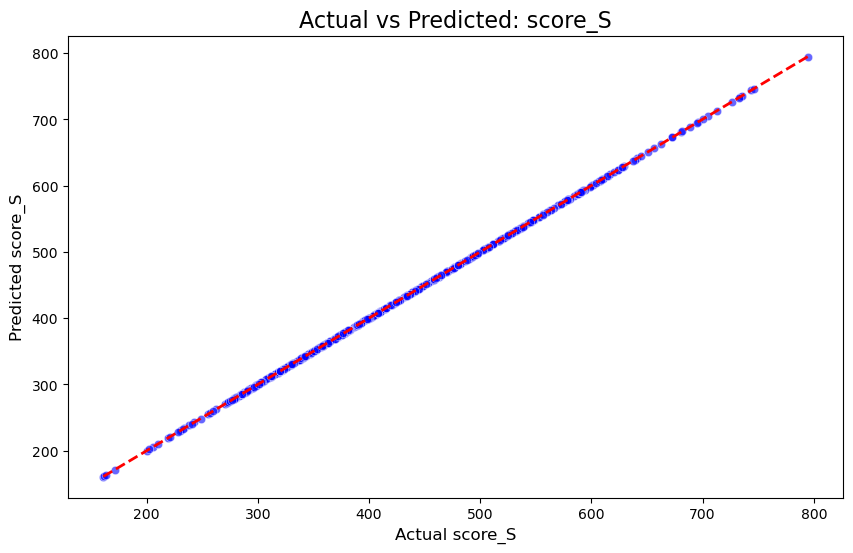

In [48]:
# Assume 'scores_ridge' is the DataFrame with the actual values and 'norm_*' columns are the input features

# Features (normalized columns) and target (score_S)
features = [f"norm_{i}" for i in weights.keys()]  # or any other feature columns
X = scores_ridge[features]
y = scores_ridge['score_S']  # Actual target values

# Train a Ridge regression model
model = Ridge(alpha=1.0)  # You can tune alpha for regularization strength
model.fit(X, y)

# Get the predicted values from the model
y_pred = model.predict(X)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y, y=y_pred, color='blue', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)  # Ideal line (y = x)
plt.title('Actual vs Predicted: score_S', fontsize=16)
plt.xlabel('Actual score_S', fontsize=12)
plt.ylabel('Predicted score_S', fontsize=12)
plt.show()


### Ridge regression model - residuals

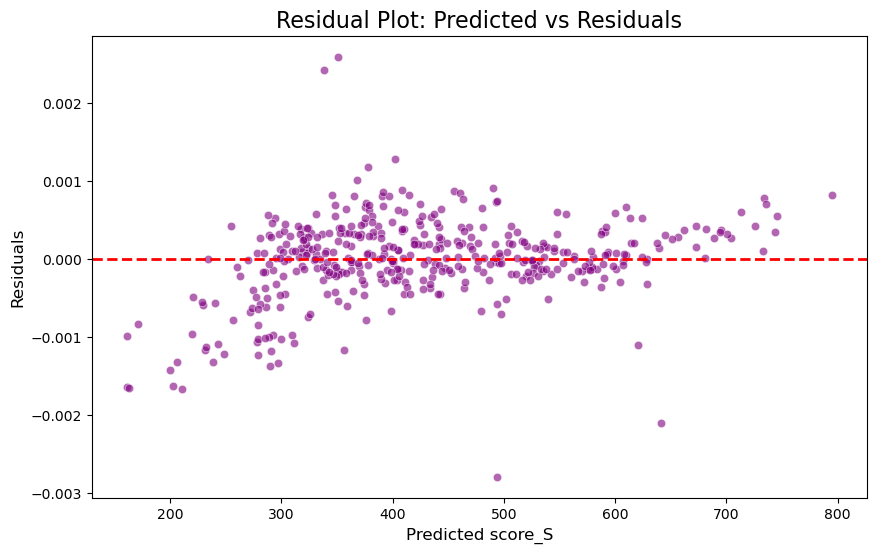

In [49]:
# Calculate residuals
residuals = y - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, color='purple', alpha=0.6)
plt.axhline(0, color='red', linestyle='--', lw=2)  # Line at residual = 0
plt.title('Residual Plot: Predicted vs Residuals', fontsize=16)
plt.xlabel('Predicted score_S', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.show()


### Box Plot of Scores by Grade

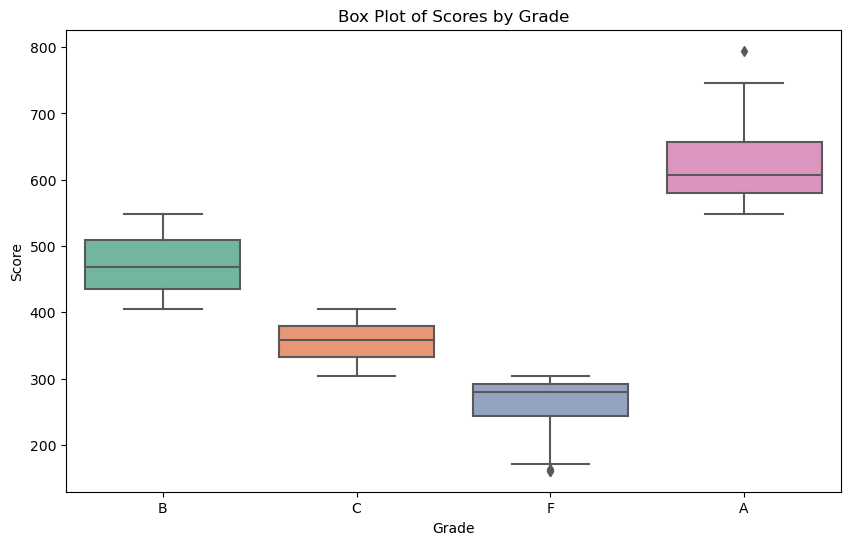

In [50]:
# Assuming 'score_S' is the continuous score column and 'Grade' is the categorical grade column
plt.figure(figsize=(10, 6))
sns.boxplot(x='Grade', y='score_S', data=scores_ridge, palette="Set2")
plt.title('Box Plot of Scores by Grade')
plt.xlabel('Grade')
plt.ylabel('Score')
plt.show()


### Distribution of Normalized Scores

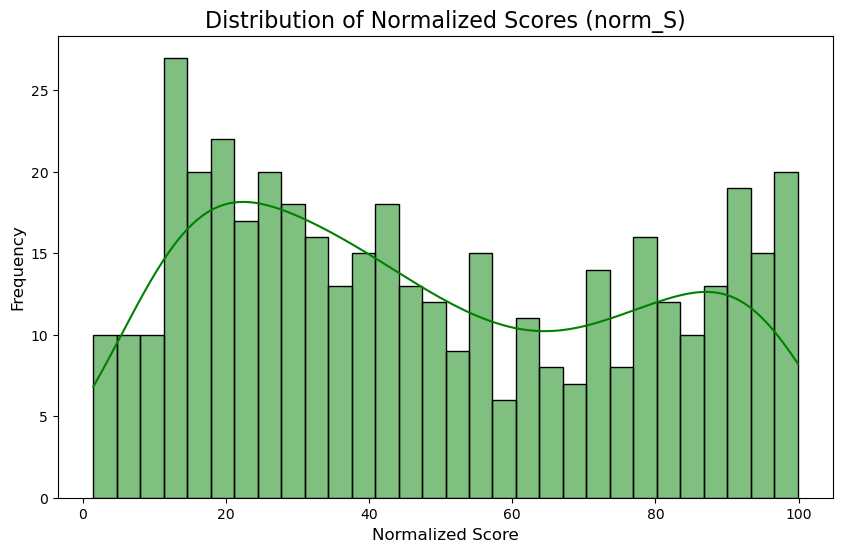

In [51]:
# Histogram for 'norm_S' score
plt.figure(figsize=(10, 6))
sns.histplot(scores_ridge['norm_S'], kde=True, bins=30, color='green')
plt.title('Distribution of Normalized Scores (norm_S)', fontsize=16)
plt.xlabel('Normalized Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()